In [3]:
# Now we are going to use the data we scraped and train a logistic regression model
# Along with making and analyzing some graphs to give insight the models predictive power

In [75]:
import pandas as pd 
import csv
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [17]:
path_stats_basic19 = r"C:\Python\March Madness\NCAA_Team_Data_basic19.csv"
path_stats_basic18 = r"C:\Python\March Madness\NCAA_Team_Data_basic18.csv"

# df of all team stats for each year
df_stats19 = pd.read_csv(path_stats_basic19)
df_stats18 = pd.read_csv(path_stats_basic18)

# df picking out our stats we will use as features in our model, this is 
# useful for our our match_stats functions below

df_features19 = df_stats19[['SCHOOL','SRS','FG%','3P%', 'FT%']]
df_features18 = df_stats18[['SCHOOL','SRS','FG%','3P%', 'FT%']]

In [18]:
path_games19 = r"C:\Python\March Madness\NCAA_Reg_Season19.csv"
path_games18 = r"C:\Python\March Madness\NCAA_Reg_Season18.csv"

# df of all games played for each year
df_games19 = pd.read_csv(path_games19)
df_games18 = pd.read_csv(path_games18)

In [19]:
# lets create a function to count how many games we are missing team data for

# Since we have data on games that include some very small schools that we do not have team data on,
# we want to make sure that only a small percentage of games will be getting thrown out
# This also serves as a safety check to make sure our two data sets are working properly together

def game_error_counter(df_games,df_stats):
    errors = 0
    for index,row in df_games.iterrows():
        try:
            df_stats.loc[df_stats['SCHOOL']==row[1]].values[0][2:]
        except IndexError:
            df_games = df_games.drop([index])
            errors +=1
    print(errors)

In [20]:
game_error_counter(df_games19,df_stats19)
game_error_counter(df_games18,df_stats18)

# 63 and 60 games respecitvely, we can ignore these games from our data set as this is an expected result

63
60


In [21]:
# This function calculates the match stats of each regular season game
# skipping the games we dont have team data for and saves the result to a list

reg_season = []
def match_stats_reg_season(df_games,df_features):
    for index,row in df_games.iterrows():
        # Each game has 2 rows (one for each team) this will get rid of the redundant data
        if index%2==0: 
            try:
                reg_season.append(np.append(df_features.loc[df_features['SCHOOL']==row[1]].values[0][1:].astype(float) - 
                                            df_features.loc[df_features['SCHOOL']==row[4]].values[0][1:].astype(float)
                                            ,[row[6]]))
            except IndexError:
                pass
    return reg_season

In [22]:
match_stats_reg_season(df_games19,df_features19);
match_stats_reg_season(df_games18,df_features18);

In [36]:
# Define our feature set and create our final dataframe holding the match stats and outcome

features = ['SRS','FG%','3P%','FT%']

df_match_stats_reg_season = pd.DataFrame(columns=['SRS','FG%','3P%','FT%','W/L'],data=reg_season)

#encode the categorical variables: 0 is a win, 1 is a loss
df_match_stats_reg_season['W/L'] = pd.get_dummies(df_match_stats_reg_season['W/L']) 
df_match_stats_reg_season = df_match_stats_reg_season.astype(float)

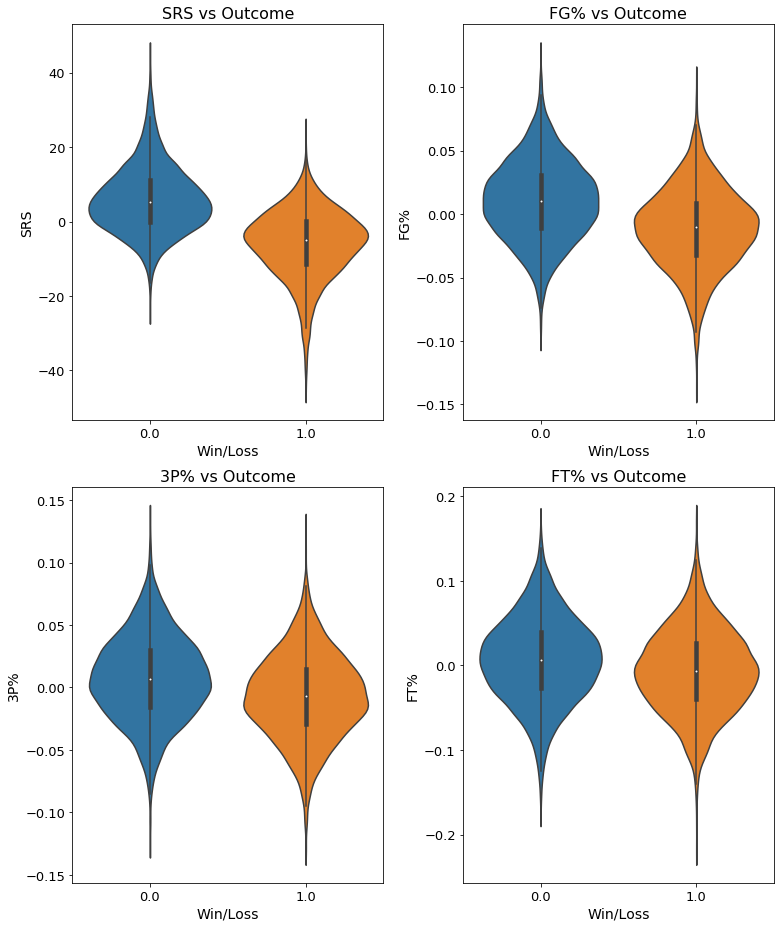

In [116]:
# Using violin plots we can graph each feature against match outcomes
# This will help us visually determine if our features correlate to winning


# SRS vs Outcome
# SRS = simple rating system
# This stat measures a teams strength of schedule since weaker opponents 
# will generally yield higher statistics that can skew data

fig, ax = plt.subplots(2,2,figsize=(11,13))

srs = sns.violinplot(y='SRS', x='W/L',
                 data=df_match_stats_reg_season,
                   ax=ax[0][0])
srs.axes.set_title("SRS vs Outcome",
                    fontsize=16)
srs.set_xlabel("Win/Loss", 
                fontsize=14)
srs.set_ylabel("SRS",
                fontsize=14)
srs.tick_params(labelsize=13)


# FG% vs Outcome
# FG% = field goal percentage 
# The percent chance a team has of making any given shot
fgp = sns.violinplot(y='FG%', x='W/L',
                 data=df_match_stats_reg_season,
                   ax=ax[0][1])

fgp.axes.set_title("FG% vs Outcome",
                    fontsize=16)
fgp.set_xlabel("Win/Loss", 
                fontsize=14)
fgp.set_ylabel("FG%",
                fontsize=14)
fgp.tick_params(labelsize=13)


# 3P% vs Outcome
# 3P% = three point percentage 
# The percent chance a team has of making a three point shot
tpp = sns.violinplot(y='3P%', x='W/L',
                 data=df_match_stats_reg_season,
                   ax=ax[1][0])

tpp.axes.set_title("3P% vs Outcome",
                    fontsize=16)
tpp.set_xlabel("Win/Loss", 
                fontsize=14)
tpp.set_ylabel("3P%",
                fontsize=14)
tpp.tick_params(labelsize=13)


# FT% vs Outcome
# FT% = free throw percentage 
# The percent chance a team has of making any given free throw attempt
ftp = sns.violinplot(y='FT%', x='W/L',
                 data=df_match_stats_reg_season,
                   ax=ax[1][1])

ftp.axes.set_title("FT% vs Outcome",
                    fontsize=16)
ftp.set_xlabel("Win/Loss", 
                fontsize=14)
ftp.set_ylabel("FT%",
                fontsize=14)
ftp.tick_params(labelsize=13)

plt.tight_layout()

In [111]:
# Judging from these graphs all 4 features seem to be relatively good indicators of success
# We expect a positive mean for winning teams and vice versa, which is consistent with what is observed

# SRS seems to be the strongest of the four due to the large difference in mean values
# and since each violin is further stretched in one direction, that indicates a very high
# success rate for outlier matchups where the difference in srs is quite large

# Free throw percentage seems to have the weakest correlation due to similar means and distributions

# In future updates we will make similar graphs for advanced statistcs such as off/def efficiency ratings,
# True shooting percentages, pace and others

In [113]:
# Train our model

all_x = df_match_stats_reg_season[features]
all_y = df_match_stats_reg_season['W/L'] 

model = LogisticRegression()
model.fit(all_x, all_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
# Serializing our model to a file called finalized_model.sav

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [115]:
# Now we can check the accuracy score by splitting our training data into two sets
# We will train the model with one set and predict the other to test accuracy

xTrain, xTest, yTrain, yTest = train_test_split(all_x,all_y,test_size = 0.2, random_state=0)

model = LogisticRegression()
model.fit(xTrain, yTrain)

holdout_predicitons = model.predict(xTest)

score = accuracy_score(yTest, holdout_predicitons)

score

# Our model predicts with an accuracy of 76.385%

0.76385104450499541